In [1]:
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb
from tigramite.models import LinearMediation, Prediction
from scipy import signal
from sklearn.linear_model import LinearRegression


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/tianyl/opt/anaconda3/lib/python3.9/site-packages/tigramite/data_processing.py:1133: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _get_patterns(array, array_mask, patt, patt_mask, weights, dim, step, fac, N, T):
/Users/tianyl/opt/anaconda3/lib/python3.9/site-packages/tigramite/plotting.py:26: UserWarning: [Errno 2] No such file or directory: '/Users/tianyl/opt/anaconda3/lib/python3.9/site-packages/tigramite/../versions.py'
  warnings.warn(str(e))
/Users/tianyl/opt/anaconda3/lib/python3.9/site-packages/tigramite/independence_tests/gpdc.py:27: UserWarning: No module named 'dcor'
  warnings.warn(str(e))
/Users/tianyl/opt/anaconda3/lib/python3.9/site-packages/tigrami

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import copy
from netCDF4 import Dataset, num2date, date2num
import more_itertools as mit
from scipy import arange, cos, exp
from scipy.interpolate import RegularGridInterpolator
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn import metrics
from matplotlib import pyplot
import matplotlib.patches as patches
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

import xarray as xr
import seaborn as sns

from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator


from matplotlib import colors as c
import matplotlib.patches as mpatches
from tslearn.utils import to_time_series_dataset
import cartopy.feature as cf
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl


from scipy.stats import rankdata
# Global Spatial Autocorrelation
#from spatial_autocorrelation import get_moransI, moransI_scatterplot, hypothesis_testing
# Local Spatial Autocorrelation
#from spatial_autocorrelation import get_localMoransI, LISA_scatterplot
from scipy.stats import linregress
import scipy
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import random
import pandas as pd
from scipy import stats
import pymannkendall as mk
from matplotlib.ticker import FormatStrFormatter

In [3]:
def p_LinearRegression(X,y):

    lm = LinearRegression()
    lm.fit(X,y)
    params = np.append(lm.intercept_,lm.coef_)
    predictions = lm.predict(X)
    new_X = np.append(np.ones((len(X),1)), X, axis=1)
    M_S_E = (sum((y-predictions)**2))/(len(new_X)-len(new_X[0]))
    v_b = M_S_E*(np.linalg.inv(np.dot(new_X.T,new_X)).diagonal())
    s_b = np.sqrt(v_b)
    t_b = params/ s_b
    p_val =[2*(1-stats.t.cdf(np.abs(i),(len(new_X)-len(new_X[0])))) for i in t_b]
    p_val = np.round(p_val,3)
    return lm.coef_,lm.intercept_,p_val

In [4]:
def p_sig(X,y,n_y_out):
    s = mk.original_test(y)[7]
    n_years_all = len(y)
    random.seed(147)
    print(random.random()) 
    #n_y_out = 3
    n_trial = 1000
    indices_random = np.zeros(( n_trial,n_years_all)) # .astype('bool')
    #Generate 5 random numbers between 10 and 30
    for i in range(n_trial):
        for j in len(n_years_all):
            randomlist = random.sample(range(0, n_years_all), 1)
            indices_random[i,j] = randomlist
    s_all = [] 
    for mask in indices_random:
        s_all.append(mk.original_test([y[int(i)] for i in mask])[7])
    s_all = np.array(s_all)
    p = (len(s_all[s_all>np.abs(s)])+len(s_all[s_all<-np.abs(s)]))/1000
    return s,p


# land mask, time and spatial information

In [5]:

NCname = r'/Users/tianyl/Desktop/Study/4_summer school in como/CEU_CEN_data/ERA5_Z500_6h_1979-2020_daymean_del29feb_1x1_5days.nc'
NCData = Dataset(NCname)
#t2m = NCData.variables['t2m'][:]
#t2m[t2m==-32767.] = np.nan
print(NCData.variables['lon'][:][:10])
time = NCData.variables['time']
dates = list(num2date(time[:], time.units, time.calendar))
year_era5_all = np.array([date.year for date in dates])
mon_era5_all = np.array([date.month for date in dates])
day_era5_all = np.array([date.day for date in dates])
NCData.close()


[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


In [6]:
def remove_seasonal(var,yearN,stepN):
    var_detrend = np.zeros_like(var)
    for i_box in range(stepN):
        temp = np.array([var[stepN*i_year+i_box] for i_year in range(yearN)])
        temp = temp - np.array(len(temp)*[np.nanmean(temp,axis=0)])
        #temp = signal.detrend(temp,axis=0)
        for i_year in range(yearN):
            var_detrend[stepN*i_year+i_box]  = temp[i_year]
    return var_detrend 

In [7]:
def remove_seasonal_normalized(var,yearN,stepN):
    var_detrend = np.zeros_like(var)
    for i_box in range(stepN):
        temp = np.array([var[stepN*i_year+i_box] for i_year in range(yearN)])
        temp = (temp - np.array(len(temp)*[np.nanmean(temp,axis=0)]))/np.array(len(temp)*[np.nanstd(temp,axis=0)])
        #temp = signal.detrend(temp,axis=0)
        for i_year in range(yearN):
            var_detrend[stepN*i_year+i_box]  = temp[i_year]
    return var_detrend 

# Central europe region

In [8]:
stepN = len(year_era5_all[year_era5_all==1979])
yearN = 42

In [9]:
lb_EU = 3
rb_EU = 18
bb_EU = 45
tb_EU = 55

# read and prepare variables

In [10]:
t2m_region_o = np.array(xr.open_dataset('/Users/tianyl/Desktop/Study/4_summer school in como/CEU_CEN_data/t2m_region.nc')['__xarray_dataarray_variable__'][:][:])
tp_region_o = np.array(xr.open_dataset('/Users/tianyl/Desktop/Study/4_summer school in como/CEU_CEN_data/tp_region.nc')['__xarray_dataarray_variable__'][:][:])
PET_region_o = np.array(xr.open_dataset('/Users/tianyl/Desktop/Study/4_summer school in como/CEU_CEN_data/PET_region.nc')['__xarray_dataarray_variable__'][:][:])
WSD_region_o = tp_region_o*1000*24-PET_region_o

z500_T_o = np.array(xr.open_dataset('/Users/tianyl/Desktop/Study/4_summer school in como/CEU_CEN_data/z500_T2m_6Waves.nc')['__xarray_dataarray_variable__'][:][:])
z500_WSD_o = np.array(xr.open_dataset('/Users/tianyl/Desktop/Study/4_summer school in como/CEU_CEN_data/z500_WSD_6Waves.nc')['__xarray_dataarray_variable__'][:][:])
z500_c_o = np.array(xr.open_dataset('/Users/tianyl/Desktop/Study/4_summer school in como/CEU_CEN_data/z500_compound.nc')['__xarray_dataarray_variable__'][:][:])


In [11]:
t2m_region_de = copy.deepcopy(remove_seasonal(t2m_region_o,yearN,stepN))
WSD_region_de = copy.deepcopy(remove_seasonal(tp_region_o*1000*24-PET_region_o,yearN,stepN))
HSI_de1 = copy.deepcopy(t2m_region_de)
SM_de1 = copy.deepcopy(WSD_region_de)


In [12]:
print('start week ',np.where((year_era5_all==1979)&(mon_era5_all==6))[0][0])
print('time_cycle ',len(np.where((year_era5_all==1979))[0]))
print('n_steps ',len(np.where((year_era5_all==1979)&(np.in1d(mon_era5_all,[6,7,8])))[0]))

start week  30
time_cycle  73
n_steps  19


In [13]:
n_years_all = 42
time_cycle = 73
n_steps =  19
start_week = 30 # 

n_years = n_years_all 
n_links = 3
n_lags = 4 # lags (0 to -3)

tau_min = 1
tau_max = 3
alpha_level_v = 0.05

In [14]:
np.nanmean(t2m_region_de[np.in1d(year_era5_all,2003)&np.in1d(mon_era5_all,8)])

3.1695682570409156

In [15]:
np.nanmean(WSD_region_de[np.in1d(year_era5_all,2003)&np.in1d(mon_era5_all,8)])

-2.2466745055103345

In [67]:

df = pd.read_excel('/Users/tianyl/Desktop/Study/4_summer school in como/CEU_CEN_data/Copula_input.xlsx')
print (df.columns)
SCDHI = df['SCDHI']
SCDHI_whitened = df['SCDHI_whitened']
year_a = np.array([np.nanmean(SCDHI[np.in1d(year_era5_all[np.in1d(mon_era5_all,[6,7,8])],i)]) for i in range(1979,2021)])
year_a_90 = np.array([np.nanpercentile(SCDHI[np.in1d(year_era5_all[np.in1d(mon_era5_all,[6,7,8])],i)],90) for i in range(1979,2021)])
year_a_10 = np.array([np.nanpercentile(SCDHI[np.in1d(year_era5_all[np.in1d(mon_era5_all,[6,7,8])],i)],10) for i in range(1979,2021)])
#year_a_whitened = np.array([np.nanmean(SCDHI_whitened[np.in1d(year_era5_all[np.in1d(mon_era5_all,[6,7,8])],i)]) for i in range(1979,2021)])
sequence  = np.argsort(year_a )[::-1]

Index(['year', 'mon', 'JJA_t2m', 'JJA_WSD', 'JJA_z500_T', 'JJA_Z500_WSD',
       'JJA_Z500_c', 'SCDHI', 'SCDHI_whitened'],
      dtype='object')


# Fig 5 a_b


In [68]:
X = np.arange(42)
y = copy.deepcopy(np.array(year_a))
gfg_data = copy.deepcopy(np.array(y))
# perform Mann-Kendall Trend Test
print(mk.original_test(gfg_data))
a1,b1 = mk.original_test(gfg_data)[7:9]

X = np.arange(42)
y = copy.deepcopy(np.array(0.5*year_a+0.5*year_a_90))
gfg_data = copy.deepcopy(np.array(y))
# perform Mann-Kendall Trend Test
print(mk.original_test(gfg_data))
a2,b2 = mk.original_test(gfg_data)[7:9]



Mann_Kendall_Test(trend='increasing', h=True, p=0.00010454867250042632, z=3.87978538122827, Tau=0.4169570267131243, s=359.0, var_s=8514.333333333334, slope=0.01658738807498931, intercept=-0.8412658979302112)
Mann_Kendall_Test(trend='increasing', h=True, p=3.818300770763727e-05, z=4.118207946555146, Tau=0.4425087108013937, s=381.0, var_s=8514.333333333334, slope=0.017276114125499217, intercept=-0.27247141791679486)


In [69]:

t2m_region = copy.deepcopy(t2m_region_o )
WSD_region = copy.deepcopy(WSD_region_o)

z500_T = copy.deepcopy(z500_T_o )
z500_WSD = copy.deepcopy(z500_WSD_o)
z500_c = copy.deepcopy(z500_c_o )


year_z_c = np.array([np.nanmean(z500_c[(np.in1d(year_era5_all,i))& (  np.in1d(mon_era5_all,[6,7,8]))]) for i in range(1979,2021)])
year_z_T = np.array([np.nanmean(z500_T[(np.in1d(year_era5_all,i))& (  np.in1d(mon_era5_all,[6,7,8]))]) for i in range(1979,2021)])
year_z_wsd = np.array([np.nanmean(z500_WSD[(np.in1d(year_era5_all,i))& (  np.in1d(mon_era5_all,[6,7,8]))]) for i in range(1979,2021)])

year_t2m_region = np.array([np.nanmean(t2m_region[(np.in1d(year_era5_all,i))& (  np.in1d(mon_era5_all,[6,7,8]))]) for i in range(1979,2021)])
year_WSD_region = np.array([np.nanmean(WSD_region[(np.in1d(year_era5_all,i))& (  np.in1d(mon_era5_all,[6,7,8]))]) for i in range(1979,2021)])

year_z_c_90 = np.array([np.nanpercentile(z500_c[(np.in1d(year_era5_all,i))& (  np.in1d(mon_era5_all,[6,7,8]))],90) for i in range(1979,2021)])
year_z_T_90 = np.array([np.nanpercentile(z500_T[(np.in1d(year_era5_all,i))& (  np.in1d(mon_era5_all,[6,7,8]))],90) for i in range(1979,2021)])
year_z_wsd_90 = np.array([np.nanpercentile(z500_WSD[(np.in1d(year_era5_all,i))& (  np.in1d(mon_era5_all,[6,7,8]))],90) for i in range(1979,2021)])

year_t2m_region_90 = np.array([np.nanpercentile(t2m_region[(np.in1d(year_era5_all,i))& (  np.in1d(mon_era5_all,[6,7,8]))],90) for i in range(1979,2021)])
year_WSD_region_90 = np.array([np.nanpercentile(WSD_region[(np.in1d(year_era5_all,i))& (  np.in1d(mon_era5_all,[6,7,8]))],90) for i in range(1979,2021)])


year_z_c_10 = np.array([np.nanpercentile(z500_c[(np.in1d(year_era5_all,i))& (  np.in1d(mon_era5_all,[6,7,8]))],10) for i in range(1979,2021)])
year_z_T_10 = np.array([np.nanpercentile(z500_T[(np.in1d(year_era5_all,i))& (  np.in1d(mon_era5_all,[6,7,8]))],10) for i in range(1979,2021)])
year_z_wsd_10 = np.array([np.nanpercentile(z500_WSD[(np.in1d(year_era5_all,i))& (  np.in1d(mon_era5_all,[6,7,8]))],10) for i in range(1979,2021)])

year_t2m_region_10 = np.array([np.nanpercentile(t2m_region[(np.in1d(year_era5_all,i))& (  np.in1d(mon_era5_all,[6,7,8]))],10) for i in range(1979,2021)])
year_WSD_region_10 = np.array([np.nanpercentile(WSD_region[(np.in1d(year_era5_all,i))& (  np.in1d(mon_era5_all,[6,7,8]))],10) for i in range(1979,2021)])

In [70]:
X = np.arange(42)
y = copy.deepcopy(np.array(year_z_c))
gfg_data = copy.deepcopy(np.array(y))
# perform Mann-Kendall Trend Test
print(mk.original_test(gfg_data))
a1,b1 = mk.original_test(gfg_data)[7:9]

X = np.arange(42)
y = copy.deepcopy(np.array(year_z_T ))

gfg_data = copy.deepcopy(np.array(y))
# perform Mann-Kendall Trend Test
print(mk.original_test(gfg_data))
a2,b2 = mk.original_test(gfg_data)[7:9]

X = np.arange(42)
y = copy.deepcopy(np.array(year_z_wsd))
gfg_data = copy.deepcopy(np.array(y))
# perform Mann-Kendall Trend Test
print(mk.original_test(gfg_data))
a3,b3 = mk.original_test(gfg_data)[7:9]

X = np.arange(42)
y = copy.deepcopy(np.array(year_t2m_region ))
gfg_data = copy.deepcopy(np.array(y))
# perform Mann-Kendall Trend Test
print(mk.original_test(gfg_data))
a4,b4 = mk.original_test(gfg_data)[7:9]

X = np.arange(42)
y = copy.deepcopy(np.array(year_WSD_region))
gfg_data = copy.deepcopy(np.array(y))
# perform Mann-Kendall Trend Test
print(mk.original_test(gfg_data))
a5,b5 = mk.original_test(gfg_data)[7:9]




X = np.arange(42)
y = copy.deepcopy(np.array(year_z_c_90))
gfg_data = copy.deepcopy(np.array(y))
# perform Mann-Kendall Trend Test
print(mk.original_test(gfg_data))
#a1,b1 = mk.original_test(gfg_data)[7:9]

X = np.arange(42)
y = copy.deepcopy(np.array(year_z_T_90 ))

gfg_data = copy.deepcopy(np.array(y))
# perform Mann-Kendall Trend Test
print(mk.original_test(gfg_data))
#a2,b2 = mk.original_test(gfg_data)[7:9]

X = np.arange(42)
y = copy.deepcopy(np.array(year_z_wsd_90))
gfg_data = copy.deepcopy(np.array(y))
# perform Mann-Kendall Trend Test
print(mk.original_test(gfg_data))
#a3,b3 = mk.original_test(gfg_data)[7:9]

X = np.arange(42)
y = copy.deepcopy(np.array(year_t2m_region_90 ))
gfg_data = copy.deepcopy(np.array(y))
# perform Mann-Kendall Trend Test
print(mk.original_test(gfg_data))
#a4,b4 = mk.original_test(gfg_data)[7:9]

X = np.arange(42)
y = copy.deepcopy(np.array(year_WSD_region_90))
gfg_data = copy.deepcopy(np.array(y))
# perform Mann-Kendall Trend Test
print(mk.original_test(gfg_data))
#a5,b5 = mk.original_test(gfg_data)[7:9]


X = np.arange(42)
y = copy.deepcopy(np.array(year_z_c_10))
gfg_data = copy.deepcopy(np.array(y))
# perform Mann-Kendall Trend Test
print(mk.original_test(gfg_data))
#a1,b1 = mk.original_test(gfg_data)[7:9]

X = np.arange(42)
y = copy.deepcopy(np.array(year_z_T_10 ))

gfg_data = copy.deepcopy(np.array(y))
# perform Mann-Kendall Trend Test
print(mk.original_test(gfg_data))
#a2,b2 = mk.original_test(gfg_data)[7:9]

X = np.arange(42)
y = copy.deepcopy(np.array(year_z_wsd_10))
gfg_data = copy.deepcopy(np.array(y))
# perform Mann-Kendall Trend Test
print(mk.original_test(gfg_data))
#a3,b3 = mk.original_test(gfg_data)[7:9]

X = np.arange(42)
y = copy.deepcopy(np.array(year_t2m_region_10 ))
gfg_data = copy.deepcopy(np.array(y))
# perform Mann-Kendall Trend Test
print(mk.original_test(gfg_data))
#a4,b4 = mk.original_test(gfg_data)[7:9]

X = np.arange(42)
y = copy.deepcopy(np.array(year_WSD_region_10))
gfg_data = copy.deepcopy(np.array(y))
# perform Mann-Kendall Trend Test
print(mk.original_test(gfg_data))
#a5,b5 = mk.original_test(gfg_data)[7:9]


Mann_Kendall_Test(trend='no trend', h=False, p=0.8453357931297272, z=-0.19507300799471747, Tau=-0.022067363530778164, s=-19.0, var_s=8514.333333333334, slope=-0.00016594044954203077, intercept=-0.01929623949747408)
Mann_Kendall_Test(trend='no trend', h=False, p=0.8115533673850392, z=-0.23842256532687692, Tau=-0.026713124274099883, s=-23.0, var_s=8514.333333333334, slope=-0.0002898330746958024, intercept=-0.012708020328656033)
Mann_Kendall_Test(trend='no trend', h=False, p=0.9136991092503179, z=0.1083738933303986, Tau=0.012775842044134728, s=11.0, var_s=8514.333333333334, slope=0.00022878201745936806, intercept=0.0008530490112298988)
Mann_Kendall_Test(trend='increasing', h=True, p=3.133293962065409e-07, z=5.115247765194813, Tau=0.5493612078977933, s=473.0, var_s=8514.333333333334, slope=0.06975246785991847, intercept=293.4666876445636)
Mann_Kendall_Test(trend='decreasing', h=True, p=0.041607050718883265, z=-2.0374291946114935, Tau=-0.21951219512195122, s=-189.0, var_s=8514.333333333334,

In [25]:

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

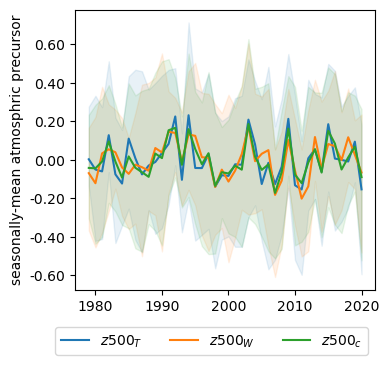

In [27]:
fig = plt.figure(figsize=(4,4))
ax1 = plt.axes((0.18,0.2,0.75,0.7))

ax1.plot(year_z_T ,label='$z500_{T}$',c=colors[0])
ax1.fill_between(range(len(year_z_T)),year_z_T_10,year_z_T_90,alpha=0.1,color=colors[0])
ax1.plot(year_z_wsd ,label='$z500_{W}$',c=colors[1])
ax1.fill_between(range(len(year_z_wsd)),year_z_wsd_10,year_z_wsd_90,alpha=0.1,color=colors[1])
ax1.plot(year_z_c ,label='$z500_{c}$',c=colors[2])
ax1.fill_between(range(len(year_z_c)),year_z_c_10,year_z_c_90,alpha=0.1,color=colors[2])
# ax1.scatter(range(42),year_z_c )
# ax1.scatter(range(42),year_z_T)
# ax1.scatter(range(42),year_z_wsd )

plt.xticks(range(1,42)[::10],np.arange(1980,2021)[::10])

ax1.legend(ncol=3,bbox_to_anchor=(1, -0.11))
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.set_ylabel('seasonally-mean atmosphric precursor')
# plt.title('Atmosphric precursor')
plt.savefig('Fig_5b_compound_trend_z500_std.jpg',dpi=600)

In [28]:
year_t2m_region_std = (year_t2m_region-np.nanmean(year_t2m_region))/np.std(year_t2m_region)
year_WSD_region_std = (year_WSD_region-np.nanmean(year_WSD_region))/np.std(year_WSD_region)
year_c_region_std = (year_a-np.nanmean(year_a))/np.std(year_a)

X = np.arange(42)
y = copy.deepcopy(np.array(year_t2m_region_std ))
gfg_data = copy.deepcopy(np.array(y))
# perform Mann-Kendall Trend Test
print(mk.original_test(gfg_data))
a4_std,b4_std = mk.original_test(gfg_data)[7:9]

X = np.arange(42)
y = copy.deepcopy(np.array(year_WSD_region_std ))
gfg_data = copy.deepcopy(np.array(y))
# perform Mann-Kendall Trend Test
print(mk.original_test(gfg_data))
a5_std,b5_std = mk.original_test(gfg_data)[7:9]

X = np.arange(42)
y = copy.deepcopy(np.array(year_c_region_std))
gfg_data = copy.deepcopy(np.array(y))
# perform Mann-Kendall Trend Test
print(mk.original_test(gfg_data))
a1_std,b1_std = mk.original_test(gfg_data)[7:9]

Mann_Kendall_Test(trend='increasing', h=True, p=3.133293962065409e-07, z=5.115247765194813, Tau=0.5493612078977933, s=473.0, var_s=8514.333333333334, slope=0.05813531655329767, intercept=-1.279747412912977)
Mann_Kendall_Test(trend='decreasing', h=True, p=0.041607050718883265, z=-2.0374291946114935, Tau=-0.21951219512195122, s=-189.0, var_s=8514.333333333334, slope=-0.024208914137655857, intercept=0.5878219988291513)
Mann_Kendall_Test(trend='increasing', h=True, p=0.00010454867250042632, z=3.87978538122827, Tau=0.4169570267131243, s=359.0, var_s=8514.333333333334, slope=0.04454911860896514, intercept=-1.037629687722226)


In [29]:

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

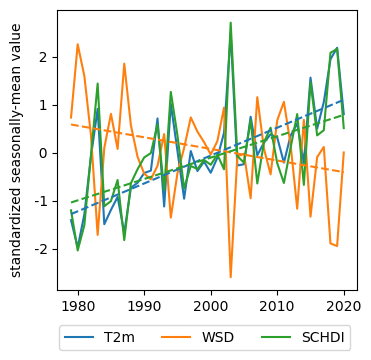

In [30]:
fig = plt.figure(figsize=(4,4))
ax1 = plt.axes((0.18,0.2,0.75,0.7))

lns1 = ax1.plot(year_t2m_region_std ,label='T2m',c=colors[0])
lns2 = ax1.plot(year_WSD_region_std ,label='WSD',c=colors[1])
lns3 = ax1.plot(np.arange(42),year_c_region_std,label='SCHDI',c=colors[2])
# ax1.scatter(range(42),year_t2m_region ,c='b')
# ax2.scatter(range(42),year_WSD_region ,c='orange')
ax1.plot(np.arange(42),np.arange(42)*a4_std+b4_std,label='T2m',c=colors[0],linestyle='--')
ax1.plot(np.arange(42),np.arange(42)*a5_std+b5_std,label='WSD',c=colors[1],linestyle='--')
ax1.plot(np.arange(42),np.arange(42)*a1_std+b1_std,label='SCHDI',c=colors[2],linestyle='--')
# ax1.fill_between(range(len(year_t2m_region)),year_t2m_region_10,year_t2m_region_90,alpha=0.1,color='#1f77b4')
# ax2.fill_between(range(len(year_WSD_region)),year_WSD_region_10,year_WSD_region_90,alpha=0.1,color='#ff7f0e')

# added these three lines
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs,ncol=3,bbox_to_anchor=(1, -0.1))

plt.xticks(range(1,42)[::10],np.arange(1980,2021)[::10])

ax1.set_ylabel('standardized seasonally-mean value')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%3d'))
# plt.title('Single climate sensor')
plt.savefig('Fig_5a_compound_trend_sensor_std.jpg',dpi=600)


# Initialize conditional independence test

Parameters:
independence test = par_corr
significance = analytic
mask_type = y

##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 3
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable z500_T has 4 link(s):
    [pc_alpha = 0.5]
        (z500_T -1): max_pval = 0.00000, min_val =  0.318
        (T2m -1): max_pval = 0.00008, min_val = -0.140
        (z500_WSD -2): max_pval = 0.40143, min_val = -0.030
        (T2m -2): max_pval = 0.48299, min_val = -0.025

    Variable z500_WSD has 2 link(s):
    [pc_alpha = 0.05]
        (z500_WSD -1): max_pval = 0.00000, min_val =  0.297
        (z500_WSD -2): max_pval = 0.00638, min_val =  0.096

    Variable T2m has 5 link(s):
    [pc_alpha = 0.2]
        (z500_T -1): max_pval = 0.00000, min_val =  0.263
        (WSD -1): max_pval = 0.00000, min_val = -0

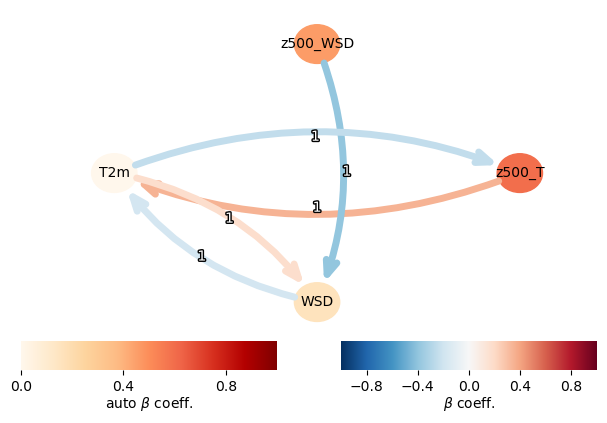

In [34]:
fulldata =np.vstack( ( z500_T/np.nanstd(z500_T),z500_WSD/np.nanstd(z500_WSD),t2m_region/np.nanstd(t2m_region),  WSD_region/np.nanstd(WSD_region) )).T
var_names =  [ 'z500_T','z500_WSD', 'T2m' ,  'WSD']
data = fulldata


# loop for SENSITIVITY test
data_mask = np.ones(data.shape, dtype='bool')
for r in range(42):
    data_mask[(start_week+r*time_cycle):(start_week+r*time_cycle + n_steps)] = False
    #mask_test[(r*time_cycle):(r*time_cycle + time_cycle)] = False



T, N = data.shape

# Initialize dataframe object (needed for tigramite functions)
#dataframe = pp.DataFrame(data, mask=data_mask)
dataframe = pp.DataFrame(data, datatime = np.arange(len(data)), var_names=var_names,mask=data_mask)



parcorr = ParCorr(significance='analytic', 
                mask_type='y', 
                verbosity=1)
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    selected_variables=None,
    verbosity=1)


results = pcmci.run_pcmci(tau_max=tau_max,tau_min=tau_min, pc_alpha = None)#[0.001, 0.01,0.05, 0.1, 0.2])#None) 
            
alpha_level_v = 0.05

pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
       # q_matrix = q_matrix,
       # p_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = alpha_level_v)

q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=tau_max, fdr_method='fdr_bh')

        
graph = pcmci.get_graph_from_pmatrix(p_matrix=q_matrix, alpha_level=alpha_level_v, 
            tau_min=tau_min, tau_max=tau_max)
results['graph'] = graph



all_parents = pcmci.return_parents_dict(graph, val_matrix=results['val_matrix'], include_lagzero_parents=True) # include_lagzero_parents=False
# Save
dictionary = all_parents #{'hello':'world'}
np.save('name_DICTIONARY_single.npy', dictionary)   


med = LinearMediation(dataframe=dataframe,            

            mask_type = 'y',
            data_transform = None)
med.fit_model(all_parents = all_parents, tau_max=tau_max)             
Links = med.get_val_matrix()
Links = med.get_val_matrix()
tp.plot_graph(
    val_matrix=Links,
    vmax_edges=1,
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label=r'${\beta}$ coeff.',
    node_colorbar_label=r'auto ${\beta}$ coeff.',
   save_name='Network_all_single.jpg'
    ); plt.show()


# Initialize conditional independence test

Parameters:
independence test = par_corr
significance = analytic
mask_type = y

##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 3
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable z500_c has 3 link(s):
    [pc_alpha = 0.05]
        (z500_c -1): max_pval = 0.00000, min_val =  0.390
        (z500_c -2): max_pval = 0.01892, min_val =  0.083
        (T2m -1): max_pval = 0.02618, min_val = -0.079

    Variable T2m has 4 link(s):
    [pc_alpha = 0.4]
        (z500_c -1): max_pval = 0.00000, min_val =  0.296
        (WSD -1): max_pval = 0.00002, min_val = -0.150
        (T2m -1): max_pval = 0.01428, min_val =  0.087
        (z500_c -2): max_pval = 0.36851, min_val = -0.032

    Variable WSD has 3 link(s):
    [pc_alpha = 0.05]
        (z500_c -1): max_pval = 0.00000, min_val = -0.211
     

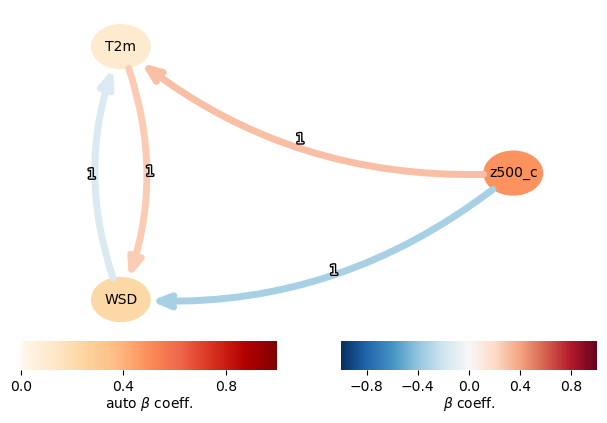

0.29920699478328944
0.10348900339469005
-0.15463584626372057
-0.33204279013361165
0.25067721261589837
0.22358286695062035


In [127]:


t2m_region = copy.deepcopy(t2m_region_o)
WSD_region = copy.deepcopy(WSD_region_o )

z500_T = copy.deepcopy(z500_T_o )
z500_WSD = copy.deepcopy(z500_WSD_o )
z500_c = copy.deepcopy(z500_c_o )

# detrend
for j in range(time_cycle):    
    # t2m_region[j::time_cycle] = scipy.signal.detrend(t2m_region[j::time_cycle], axis = 0)
    
    # WSD_region[j::time_cycle] = scipy.signal.detrend(WSD_region[j::time_cycle], axis = 0)
    # z500_T[j::time_cycle] = scipy.signal.detrend(z500_T[j::time_cycle], axis = 0)
    # z500_WSD[j::time_cycle] = scipy.signal.detrend(z500_WSD[j::time_cycle], axis = 0)
    # z500_c[j::time_cycle] = scipy.signal.detrend(z500_c[j::time_cycle], axis = 0)
    t2m_region[j::time_cycle] = scipy.signal.detrend(t2m_region[j::time_cycle], axis = 0)
    
    WSD_region[j::time_cycle] = scipy.signal.detrend(WSD_region[j::time_cycle], axis = 0)
    z500_T[j::time_cycle] = scipy.signal.detrend(z500_T[j::time_cycle], axis = 0)
    z500_WSD[j::time_cycle] = scipy.signal.detrend(z500_WSD[j::time_cycle], axis = 0)
    z500_c[j::time_cycle] = scipy.signal.detrend(z500_c[j::time_cycle], axis = 0)
#calculate anomalies
for i in range(int(time_cycle)):
    t2m_region[i::int(time_cycle)] = (t2m_region[i::int(time_cycle)] - np.mean(t2m_region[:time_cycle*n_years][i::int(time_cycle)], axis = 0))
    
    WSD_region[i::int(time_cycle)] = (WSD_region[i::int(time_cycle)] - np.mean(WSD_region[:time_cycle*n_years][i::int(time_cycle)], axis = 0))
    z500_T[i::int(time_cycle)] = (z500_T[i::int(time_cycle)] - np.mean(z500_T[:time_cycle*n_years][i::int(time_cycle)], axis = 0))
    z500_WSD[i::int(time_cycle)] = (z500_WSD[i::int(time_cycle)] - np.mean(z500_WSD[:time_cycle*n_years][i::int(time_cycle)], axis = 0))
    z500_c[i::int(time_cycle)] = (z500_c[i::int(time_cycle)] - np.mean(z500_c[:time_cycle*n_years][i::int(time_cycle)], axis = 0))


fulldata =np.vstack( ( z500_c/np.nanstd(z500_c),t2m_region/np.nanstd(t2m_region),  WSD_region/np.nanstd(WSD_region) )).T
var_names =  [ 'z500_c', 'T2m' ,  'WSD']
data = fulldata


# loop for SENSITIVITY test
data_mask = np.ones(data.shape, dtype='bool')
for r in range(42):
    data_mask[(start_week+r*time_cycle):(start_week+r*time_cycle + n_steps)] = False
    #mask_test[(r*time_cycle):(r*time_cycle + time_cycle)] = False



T, N = data.shape

# Initialize dataframe object (needed for tigramite functions)
#dataframe = pp.DataFrame(data, mask=data_mask)
dataframe = pp.DataFrame(data, datatime = np.arange(len(data)), var_names=var_names,mask=data_mask)



parcorr = ParCorr(significance='analytic', 
                mask_type='y', 
                verbosity=1)
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    selected_variables=None,
    verbosity=1)


results = pcmci.run_pcmci(tau_max=tau_max,tau_min=tau_min, pc_alpha = None)#[0.3, 0.1,0.05 [0.001, 0.01,0.05, 0.1, 0.2])#None)

q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=tau_max, fdr_method='fdr_bh')

graph = pcmci.get_graph_from_pmatrix(p_matrix=q_matrix, alpha_level=0.05, 
        tau_min=tau_min, tau_max=tau_max, selected_links=None)
results['graph'] = graph

sig = pcmci.return_significant_links(
                    pq_matrix=q_matrix,
                    val_matrix=results['val_matrix'], 
                    alpha_level=alpha_level_v)

# Remove some links link_matrix[i, j, tau] is link  i -- tau --> j
# link_matrix[[1,2,3,4,], :, :] = False

all_parents = pcmci.return_parents_dict(graph, val_matrix=results['val_matrix'], include_lagzero_parents=False)

#link_matrix = sig['link_matrix']
link_matrix = graph
med = LinearMediation(dataframe=dataframe,            

            mask_type = 'y',
            data_transform = None)
med.fit_model(all_parents = all_parents, tau_max=tau_max)             
Links = med.get_val_matrix()
#pcmci.print_significant_links(
    #p_matrix = results['p_matrix'], 
    #q_matrix = q_matrix,
    #p_matrix = q_matrix,
    # val_matrix = Links,
    #alpha_level = alpha_level_v)


val_matrix = med.get_val_matrix()

#link strength var 0 --> 2 at lag = 1 : print(val_matrix[0,2,1])

#print(val_matrix.shape)
#print(val_matrix_all.shape)
# save 


tp.plot_graph(
    val_matrix=Links,
    vmax_edges=1,
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label=r'${\beta}$ coeff.',
    node_colorbar_label=r'auto ${\beta}$ coeff.',
   save_name='Network_all_compound.jpg'
    ); plt.show()

print(val_matrix[ 0,1, 0 +1])
print(val_matrix[ 1,1, 0 +1])
print(val_matrix[ 2,1, 0 +1])

print(val_matrix[ 0,2, 0 +1])
print(val_matrix[ 1,2, 0 +1])
print(val_matrix[ 2,2, 0 +1])
dictionary = all_parents #{'hello':'world'}
np.save('name_DICTIONARY_compound.npy', dictionary)   



In [71]:
wsd_to_wsd1 = []
z_to_wsd1 = []
wsd_to_t1 = []
z_to_t1 = []
t_to_wsd1 = []
for i_year in range(0,31):
    val_matrix_all0 = np.zeros(( 4, 4, n_lags))
    q_matrix_all0 = np.zeros((4, 4, n_lags))

    t2m_region = copy.deepcopy(t2m_region_o)
    WSD_region = copy.deepcopy(WSD_region_o )

    z500_T = copy.deepcopy(z500_T_o )
    z500_WSD = copy.deepcopy(z500_WSD_o )
    z500_c = copy.deepcopy(z500_c_o )

    # detrend
    for j in range(time_cycle):    

        t2m_region[j::time_cycle] = scipy.signal.detrend(t2m_region[j::time_cycle], axis = 0)
        
        WSD_region[j::time_cycle] = scipy.signal.detrend(WSD_region[j::time_cycle], axis = 0)
        z500_T[j::time_cycle] = scipy.signal.detrend(z500_T[j::time_cycle], axis = 0)
        z500_WSD[j::time_cycle] = scipy.signal.detrend(z500_WSD[j::time_cycle], axis = 0)
        z500_c[j::time_cycle] = scipy.signal.detrend(z500_c[j::time_cycle], axis = 0)
    #calculate anomalies
    for i in range(int(time_cycle)):
        t2m_region[i::int(time_cycle)] = (t2m_region[i::int(time_cycle)] - np.mean(t2m_region[:time_cycle*n_years][i::int(time_cycle)], axis = 0))
        
        WSD_region[i::int(time_cycle)] = (WSD_region[i::int(time_cycle)] - np.mean(WSD_region[:time_cycle*n_years][i::int(time_cycle)], axis = 0))
        z500_T[i::int(time_cycle)] = (z500_T[i::int(time_cycle)] - np.mean(z500_T[:time_cycle*n_years][i::int(time_cycle)], axis = 0))
        z500_WSD[i::int(time_cycle)] = (z500_WSD[i::int(time_cycle)] - np.mean(z500_WSD[:time_cycle*n_years][i::int(time_cycle)], axis = 0))
        z500_c[i::int(time_cycle)] = (z500_c[i::int(time_cycle)] - np.mean(z500_c[:time_cycle*n_years][i::int(time_cycle)], axis = 0))


    fulldata =np.vstack( ( z500_T/np.nanstd(z500_T),z500_WSD/np.nanstd(z500_WSD),t2m_region/np.nanstd(t2m_region),  WSD_region/np.nanstd(WSD_region) )).T
    var_names =  [ 'z500_T','z500_WSD', 'T2m' ,  'WSD']
    data = fulldata


    # loop for SENSITIVITY test
    data_mask = np.ones(data.shape, dtype='bool')
    for r in range(i_year,i_year+10):
        data_mask[(start_week+r*time_cycle):(start_week+r*time_cycle + n_steps)] = False


    T, N = data.shape

    # Initialize dataframe object (needed for tigramite functions)
    #dataframe = pp.DataFrame(data, mask=data_mask)
    dataframe = pp.DataFrame(data, datatime = np.arange(len(data)), var_names=var_names,mask=data_mask)



    all_parents = np.load('name_DICTIONARY_single.npy', allow_pickle = True).item()

    med = LinearMediation(dataframe=dataframe,            

                mask_type = 'y',
                data_transform = None)
                
    med.fit_model(all_parents = all_parents, tau_max=tau_max)     
    val_matrix= med.get_val_matrix()  

    val_matrix_all0[0 :,:,:] = val_matrix



    z_to_wsd1.append(val_matrix_all0[1,3,1])
    wsd_to_t1.append(val_matrix_all0[3,2,1])
    t_to_wsd1.append(val_matrix_all0[2,3,1])
    z_to_t1.append(val_matrix_all0[0,2,1])
    wsd_to_wsd1.append(val_matrix_all0[3,3,1])   


In [128]:
z_to_t2 = []
z_to_wsd2 = []
t_to_wsd2 = []
wsd_to_t2 = []
wsd_to_wsd2 = []

for i_year in range(0,31):
    val_matrix_all0 = np.zeros(( 3, 3, n_lags))
    q_matrix_all0 = np.zeros((3, 3, n_lags))

    t2m_region = copy.deepcopy(t2m_region_o)
    WSD_region = copy.deepcopy(WSD_region_o )

    z500_T = copy.deepcopy(z500_T_o )
    z500_WSD = copy.deepcopy(z500_WSD_o )
    z500_c = copy.deepcopy(z500_c_o )

    # detrend
    for j in range(time_cycle):    
        # t2m_region[j::time_cycle] = scipy.signal.detrend(t2m_region[j::time_cycle], axis = 0)
        
        # WSD_region[j::time_cycle] = scipy.signal.detrend(WSD_region[j::time_cycle], axis = 0)
        # z500_T[j::time_cycle] = scipy.signal.detrend(z500_T[j::time_cycle], axis = 0)
        # z500_WSD[j::time_cycle] = scipy.signal.detrend(z500_WSD[j::time_cycle], axis = 0)
        # z500_c[j::time_cycle] = scipy.signal.detrend(z500_c[j::time_cycle], axis = 0)
        t2m_region[j::time_cycle] = scipy.signal.detrend(t2m_region[j::time_cycle], axis = 0)
        
        WSD_region[j::time_cycle] = scipy.signal.detrend(WSD_region[j::time_cycle], axis = 0)
        z500_T[j::time_cycle] = scipy.signal.detrend(z500_T[j::time_cycle], axis = 0)
        z500_WSD[j::time_cycle] = scipy.signal.detrend(z500_WSD[j::time_cycle], axis = 0)
        z500_c[j::time_cycle] = scipy.signal.detrend(z500_c[j::time_cycle], axis = 0)
    #calculate anomalies
    for i in range(int(time_cycle)):
        t2m_region[i::int(time_cycle)] = (t2m_region[i::int(time_cycle)] - np.mean(t2m_region[:time_cycle*n_years][i::int(time_cycle)], axis = 0))
        
        WSD_region[i::int(time_cycle)] = (WSD_region[i::int(time_cycle)] - np.mean(WSD_region[:time_cycle*n_years][i::int(time_cycle)], axis = 0))
        z500_T[i::int(time_cycle)] = (z500_T[i::int(time_cycle)] - np.mean(z500_T[:time_cycle*n_years][i::int(time_cycle)], axis = 0))
        z500_WSD[i::int(time_cycle)] = (z500_WSD[i::int(time_cycle)] - np.mean(z500_WSD[:time_cycle*n_years][i::int(time_cycle)], axis = 0))
        z500_c[i::int(time_cycle)] = (z500_c[i::int(time_cycle)] - np.mean(z500_c[:time_cycle*n_years][i::int(time_cycle)], axis = 0))


    fulldata =np.vstack( ( z500_c/np.nanstd(z500_c),t2m_region/np.nanstd(t2m_region),  WSD_region/np.nanstd(WSD_region) )).T
    var_names =  [ 'z500_c', 'T2m' ,  'WSD']
    data = fulldata


    # loop for SENSITIVITY test
    data_mask = np.ones(data.shape, dtype='bool')
    for r in range(i_year,i_year+10):
        data_mask[(start_week+r*time_cycle):(start_week+r*time_cycle + n_steps)] = False


    T, N = data.shape

    # Initialize dataframe object (needed for tigramite functions)
    #dataframe = pp.DataFrame(data, mask=data_mask)
    dataframe = pp.DataFrame(data, datatime = np.arange(len(data)), var_names=var_names,mask=data_mask)

    all_parents = np.load('name_DICTIONARY_compound.npy', allow_pickle = True).item()

    med = LinearMediation(dataframe=dataframe,            

                mask_type = 'y',
                data_transform = None)
                
    med.fit_model(all_parents = all_parents, tau_max=tau_max)     
    val_matrix= med.get_val_matrix()  

    val_matrix_all0[0 :,:,:] = val_matrix

    z_to_t2.append(val_matrix_all0[0,1,1])
    z_to_wsd2.append(val_matrix_all0[0,2,1])
    t_to_wsd2.append(val_matrix_all0[1,2,1])
    wsd_to_t2.append(val_matrix_all0[2,1,1])
    wsd_to_wsd2.append(val_matrix_all0[2,2,1])



In [129]:
random.sample(range(0, 31),1)

[6]

In [124]:
def p_sig(X,y,n_y_out):
    s = mk.original_test(y)[7]
    n_years_all = len(y)
    random.seed(147)
    print(random.random()) 
    #n_y_out = 3
    n_trial = 1000
    indices_random = np.zeros(( n_trial,n_years_all)) # .astype('bool')
    #Generate 5 random numbers between 10 and 30
    for i in range(n_trial):
        temp = []
        for j in range(n_years_all):
            if j==0:
                randomlist = random.sample(range(0, n_years_all), 1)
            else:
                randomlist = random.sample(list(np.arange(0, n_years_all)[~np.in1d(np.arange(0, n_years_all),temp)]), 1)
            indices_random[i,j] = randomlist[0]
            temp.append(randomlist)
    s_all = [] 
    for mask in indices_random:
        s_all.append(mk.original_test([y[int(i)] for i in mask])[7])
    s_all = np.array(s_all)
    p = (len(s_all[s_all>np.abs(s)])+len(s_all[s_all<-np.abs(s)]))/1000
    return s,p

# Fig 5_c_f

In [97]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [131]:

y_all = [z_to_wsd1,\
             wsd_to_wsd1,\
         t_to_wsd1,\
        z_to_t1,\
      wsd_to_t1 ]

label1_all = [r'Z500$_{W}{\rightarrow}$WSD (single event)',\
    r'WSD${\rightarrow}$WSD (single event)',\
    r'T2m${\rightarrow}$WSD (single event)',\
    r'Z500$_{T}{\rightarrow}$T2m (single event)',\
    r'WSD${\rightarrow}$T2m (single event)']

marker_all = ['s','s','s','o','o']

-0.004507026467757432 -0.35487049278534927
38.10144736787343
-0.4900812868180722
-0.35487049278534927


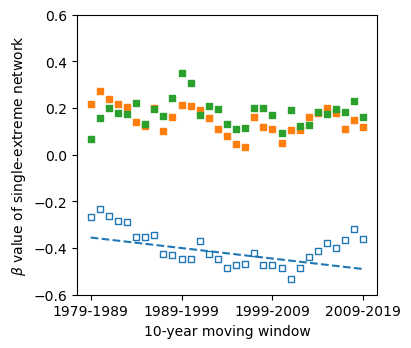

In [133]:
fig = plt.figure(figsize=(4,4))
ax = plt.axes((0.18,0.27,0.75,0.7))
X = np.array(np.arange(0,31))

for y, label1,marker,n in zip(y_all[:3],label1_all[:3],marker_all[:3],[0,1,2]):

    label = label1+', p=%.3f'%(mk.original_test(y)[2])
    if n in [0,3]:
        ax.scatter(X,np.array(y),edgecolor=colors[n],label=label,marker=marker,color='white',s=15)
    else:
        ax.scatter(X,np.array(y),label=label,color=colors[n],marker=marker,s=15)
    mk.original_test(y)  
    if mk.original_test(y)[2]<0.05 :
        gfg_data = copy.deepcopy(np.array(y))
        a1,b1 = mk.original_test(gfg_data)[7:9]
 
        print (a1,b1)
        ax.plot(X,a1*X+b1,linestyle='--',color=colors[n])
        #print(reg.score(X.reshape(-1, 1), y))
        print((a1*X[-1]-a1*X[0])/(a1*X[0]+b1)*100)
        print((a1*X[-1]+b1))
        print((a1*X[0]+b1))
        

plt.xticks(np.arange(0,35)[::10],[str(i)+'-'+str(i+10) for i in np.arange(1979,1979+35)[::10]])
ax.set_xlabel('10-year moving window')
ax.set_ylabel(r'${\beta}$ value of single-extreme network')
ax.set_ylim(-0.6,0.6)
plt.savefig('Fig 5d.Beta_value_trend_with_year_WSD_single.jpg', dpi=300)
plt.show()

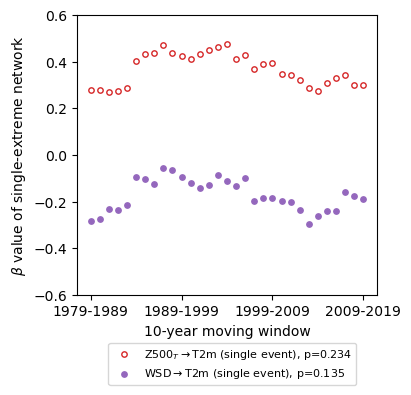

In [134]:
fig = plt.figure(figsize=(4,4))
ax = plt.axes((0.18,0.27,0.75,0.7))
X = np.array(np.arange(0,31))

for y, label1,marker,n in zip(y_all[3:],label1_all[3:],marker_all[3:],[3,4]):

    label = label1+', p=%.3f'%mk.original_test(y)[2]
    if n in [0,3]:
        ax.scatter(X,np.array(y),edgecolor=colors[n],label=label,marker=marker,color='white',s=15)
    else:
        ax.scatter(X,np.array(y),label=label,color=colors[n],marker=marker,s=15)
    mk.original_test(y)  
    if abs(mk.original_test(y)[2])<0.05 :
        reg = LinearRegression().fit(X.reshape(-1, 1), y)
        reg.score(X.reshape(-1, 1), y)
        a1 = reg.coef_
        b1=reg.intercept_
        ax.plot(X,a1*X+b1,linestyle='--',color=colors[n])
        print(a1,b1)
        print((a1*X[-1]+b1))
        print((a1*X[0]+b1))
        print((a1*X[-1]-a1*X[0])/(a1*X[0]+b1)*100)

plt.xticks(np.arange(0,35)[::10],[str(i)+'-'+str(i+10) for i in np.arange(1979,1979+35)[::10]])
ax.set_xlabel('10-year moving window')
# ax.set_title(label,fontsize=9)
ax.set_ylabel(r'${\beta}$ value of single-extreme network')
ax.set_ylim(-0.6,0.6)
plt.legend(fontsize=8,bbox_to_anchor=(0.95, -0.15))
plt.savefig('Fig 5c.Beta_value_trend_with_year_T_single.jpg', dpi=300)
plt.show()

In [135]:

y_all = [z_to_wsd2,\
             wsd_to_wsd2,\
         t_to_wsd2,\
        z_to_t2,\
      wsd_to_t2 ]

label1_all = [r'Z500$_{c}{\rightarrow}$WSD (compound event)',\
    r'WSD${\rightarrow}$WSD (compound event)',\
    r'T2m${\rightarrow}$WSD (compound event)',\
    r'Z500$_{c}{\rightarrow}$T2m (compound event)',\
    r'WSD${\rightarrow}$T2m (compound event)']

  
marker_all = ['s','s','s','o','o']

-0.004513509430936791 -0.2896537265617946
-0.4250590094898984
-0.2896537265617946
46.7472953085644


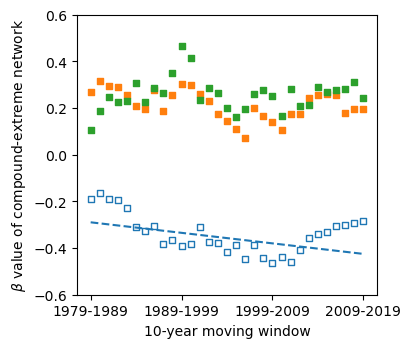

In [136]:
fig = plt.figure(figsize=(4,4))
ax = plt.axes((0.18,0.27,0.75,0.7))
X = np.array(np.arange(0,31))

for y, label1,marker,n in zip(y_all[:3],label1_all[:3],marker_all[:3],[0,1,2]):
    label = label1+', p=%.3f'%(mk.original_test(y)[2])
    if n in [0,3]:
        ax.scatter(X,np.array(y),edgecolor=colors[n],label=label,marker=marker,color='white',s=15)
    else:
        ax.scatter(X,np.array(y),label=label,color=colors[n],marker=marker,s=15)

    mk.original_test(y)  
    if abs(mk.original_test(y)[2])<0.1:
        gfg_data = copy.deepcopy(np.array(y))
        a1,b1 = mk.original_test(gfg_data)[7:9]
        ax.plot(X,a1*X+b1,linestyle='--',color=colors[n])
        print(a1,b1)
        print((a1*X[-1]+b1))
        print((a1*X[0]+b1))
        print((a1*X[-1]-a1*X[0])/(a1*X[0]+b1)*100)

plt.xticks(np.arange(0,35)[::10],[str(i)+'-'+str(i+10) for i in np.arange(1979,1979+35)[::10]])
ax.set_xlabel('10-year moving window')

ax.set_ylabel(r'${\beta}$ value of compound-extreme network')
ax.set_ylim(-0.6,0.6)

plt.savefig('Fig 5f.Beta_value_trend_with_year_WSD_compound.jpg', dpi=300)
plt.show()

-0.2043776028693478
-0.10845381793646174
-0.0031974594977628697 -0.10845381793646174
88.44666491048159


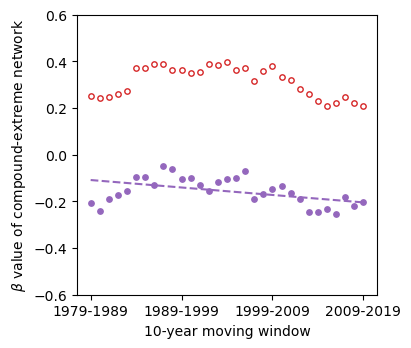

In [141]:
fig = plt.figure(figsize=(4,4))
ax = plt.axes((0.18,0.27,0.75,0.7))
X = np.array(np.arange(0,31))

for y, label1,marker,n in zip(y_all[3:],label1_all[3:],marker_all[3:],[3,4]):

    label = label1+', p=%.3f'%mk.original_test(y)[2]
    if n in [0,3]:
        ax.scatter(X,np.array(y),edgecolor=colors[n],label=label,marker=marker,color='white',s=15)
    else:
        ax.scatter(X,np.array(y),label=label,color=colors[n],marker=marker,s=15)
    mk.original_test(y)  

    if abs(mk.original_test(y)[2])<0.05:
        reg = LinearRegression().fit(X.reshape(-1, 1), y)
        reg.score(X.reshape(-1, 1), y)
        a1 = reg.coef_
        b1=reg.intercept_

        gfg_data = copy.deepcopy(np.array(y))
        a1,b1 = mk.original_test(gfg_data)[7:9]
        ax.plot(X,a1*X+b1,linestyle='--',color=colors[n])
        print((a1*X[-1]+b1))
        print((a1*X[0]+b1))
        print(a1,b1)
        print((a1*X[-1]-a1*X[0])/(a1*X[0]+b1)*100)


plt.xticks(np.arange(0,35)[::10],[str(i)+'-'+str(i+10) for i in np.arange(1979,1979+35)[::10]])
ax.set_xlabel('10-year moving window')
ax.set_ylabel(r'${\beta}$ value of compound-extreme network')
ax.set_ylim(-0.6,0.6)
plt.savefig('Fig 5e.Beta_value_trend_with_year_T_compound.jpg', dpi=300)
plt.show()